## Principal Component Analysis (PCA)

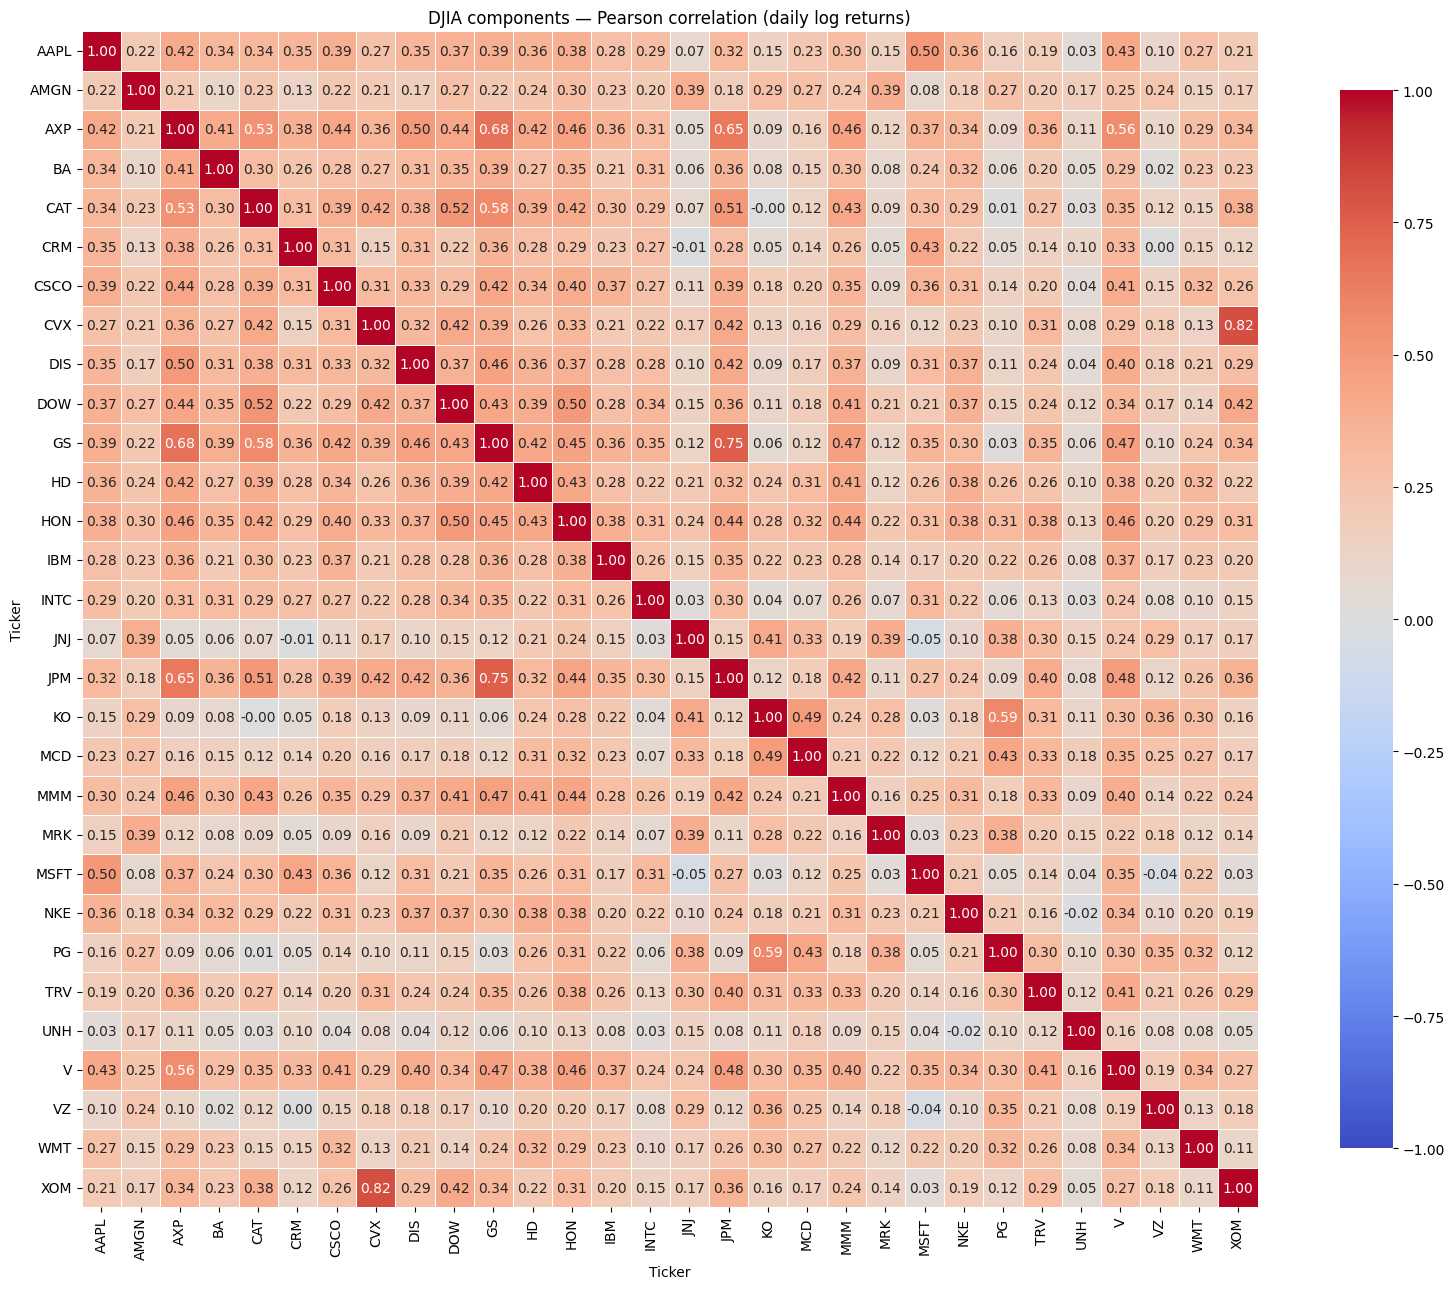

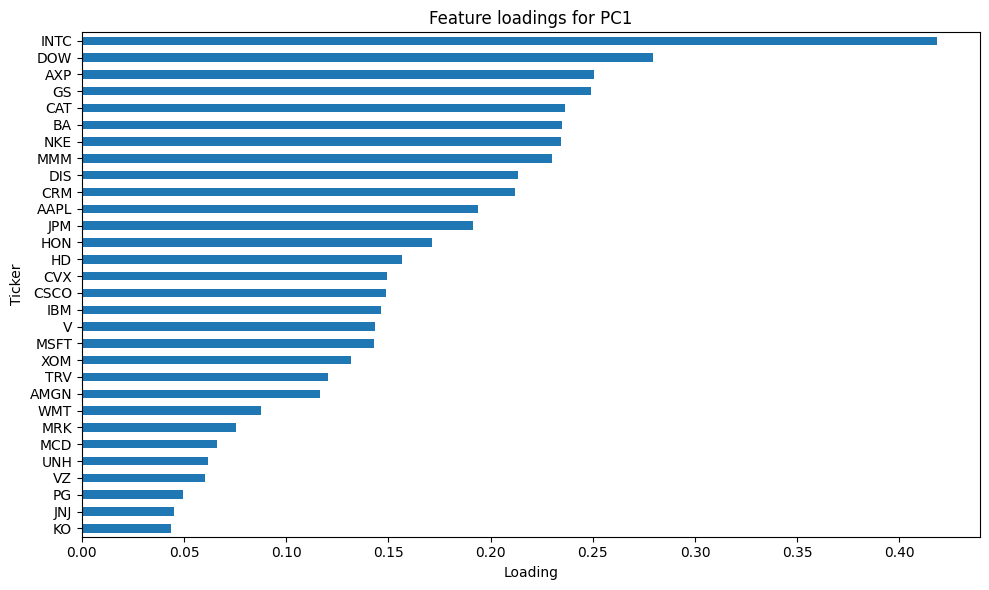

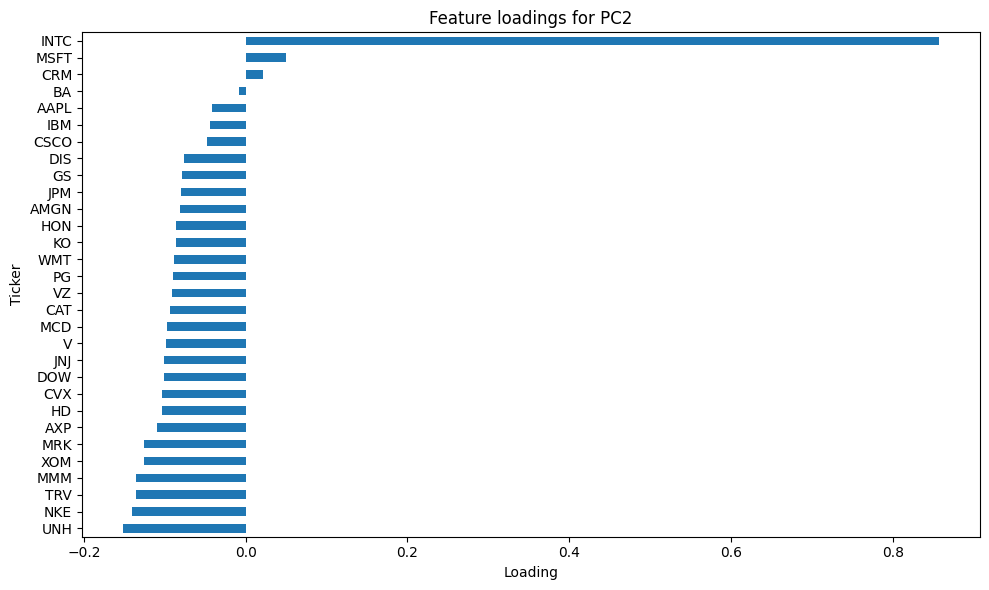

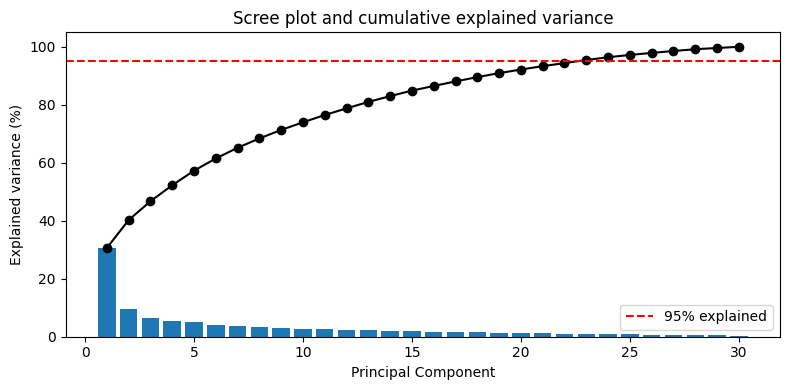

Number of components needed for 95% variance: 23


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.linalg import eigh
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import math

# 30 constituents of the Dow Jones Industrial Average
djia_tickers = [
    "AAPL","AMGN","AXP","BA","CAT","CRM","CSCO","CVX","DIS","DOW",
    "GS","HD","HON","IBM","INTC","JNJ","JPM","KO","MCD","MMM",
    "MRK","MSFT","NKE","PG","TRV","UNH","V","VZ","WMT","XOM"
]

# 2) Fetch closing prices for at least two years
end_date = pd.Timestamp.today().normalize()
start_date = end_date - pd.DateOffset(years=3)  # fetch 3 years to be safe
data = yf.download(
    djia_tickers, 
    start=start_date.strftime("%Y-%m-%d"),
    end=end_date.strftime("%Y-%m-%d"),
    auto_adjust=True, 
    progress=False)["Close"]

#print(data)

# Cleaning (drop tickers with too many missing values)
min_non_na_ratio = 0.9
valid_cols = [col for col in data.columns if data[col].notna().mean() >= min_non_na_ratio]
data = data[valid_cols].dropna() 

# Compute daily log returns
log_prices = np.log(data)
log_returns = log_prices.diff().dropna()

# Plotting Pearson correlation matrix for returns
corr = log_returns.corr()
# Plot correlation heatmap
fig, ax = plt.subplots(figsize=(17, 13))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", 
            linewidths=0.5, center=0, vmin=-1, vmax=1,
            square=True, cbar_kws={"shrink": 0.9},ax=ax)
plt.title("DJIA components — Pearson correlation (daily log returns)")
plt.tight_layout()
plt.show()

# PCA decompostition
pca = PCA()
pca.fit(log_returns.fillna(0))  # sklearn works on samples x features shape

# Get loadings
loadings = pd.DataFrame(pca.components_.T, index=log_returns.columns,
                        columns=[f"PC{i+1}" for i in range(len(log_returns.columns))])

explained_variance = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained_variance)

# Bar chart for PC1 and PC2 loadings
for pc in ["PC1","PC2"]:
    fig, ax = plt.subplots(figsize=(10,6))
    loadings[pc].sort_values().plot(kind='barh',ax=ax)
    plt.title(f"Feature loadings for {pc}")
    plt.xlabel("Loading")
    plt.tight_layout()
    plt.show()

# Scree plot and cumulative variance
plt.figure(figsize=(8,4))
plt.bar(range(1, len(explained_variance)+1), explained_variance*100)
plt.plot(range(1, len(explained_variance)+1), cum_explained*100, marker='o', color='k')
plt.axhline(95, color='red', linestyle='--', label='95% explained')
plt.xlabel("Principal Component")
plt.ylabel("Explained variance (%)")
plt.title("Scree plot and cumulative explained variance")
plt.legend()
plt.tight_layout()
plt.show()

# k for 95% explained variance
k_95 = np.searchsorted(cum_explained, 0.95) + 1  # +1 because searchsorted gives index
print(f"Number of components needed for 95% variance: {k_95}")


## Question 2 (2.2 - 2.3)

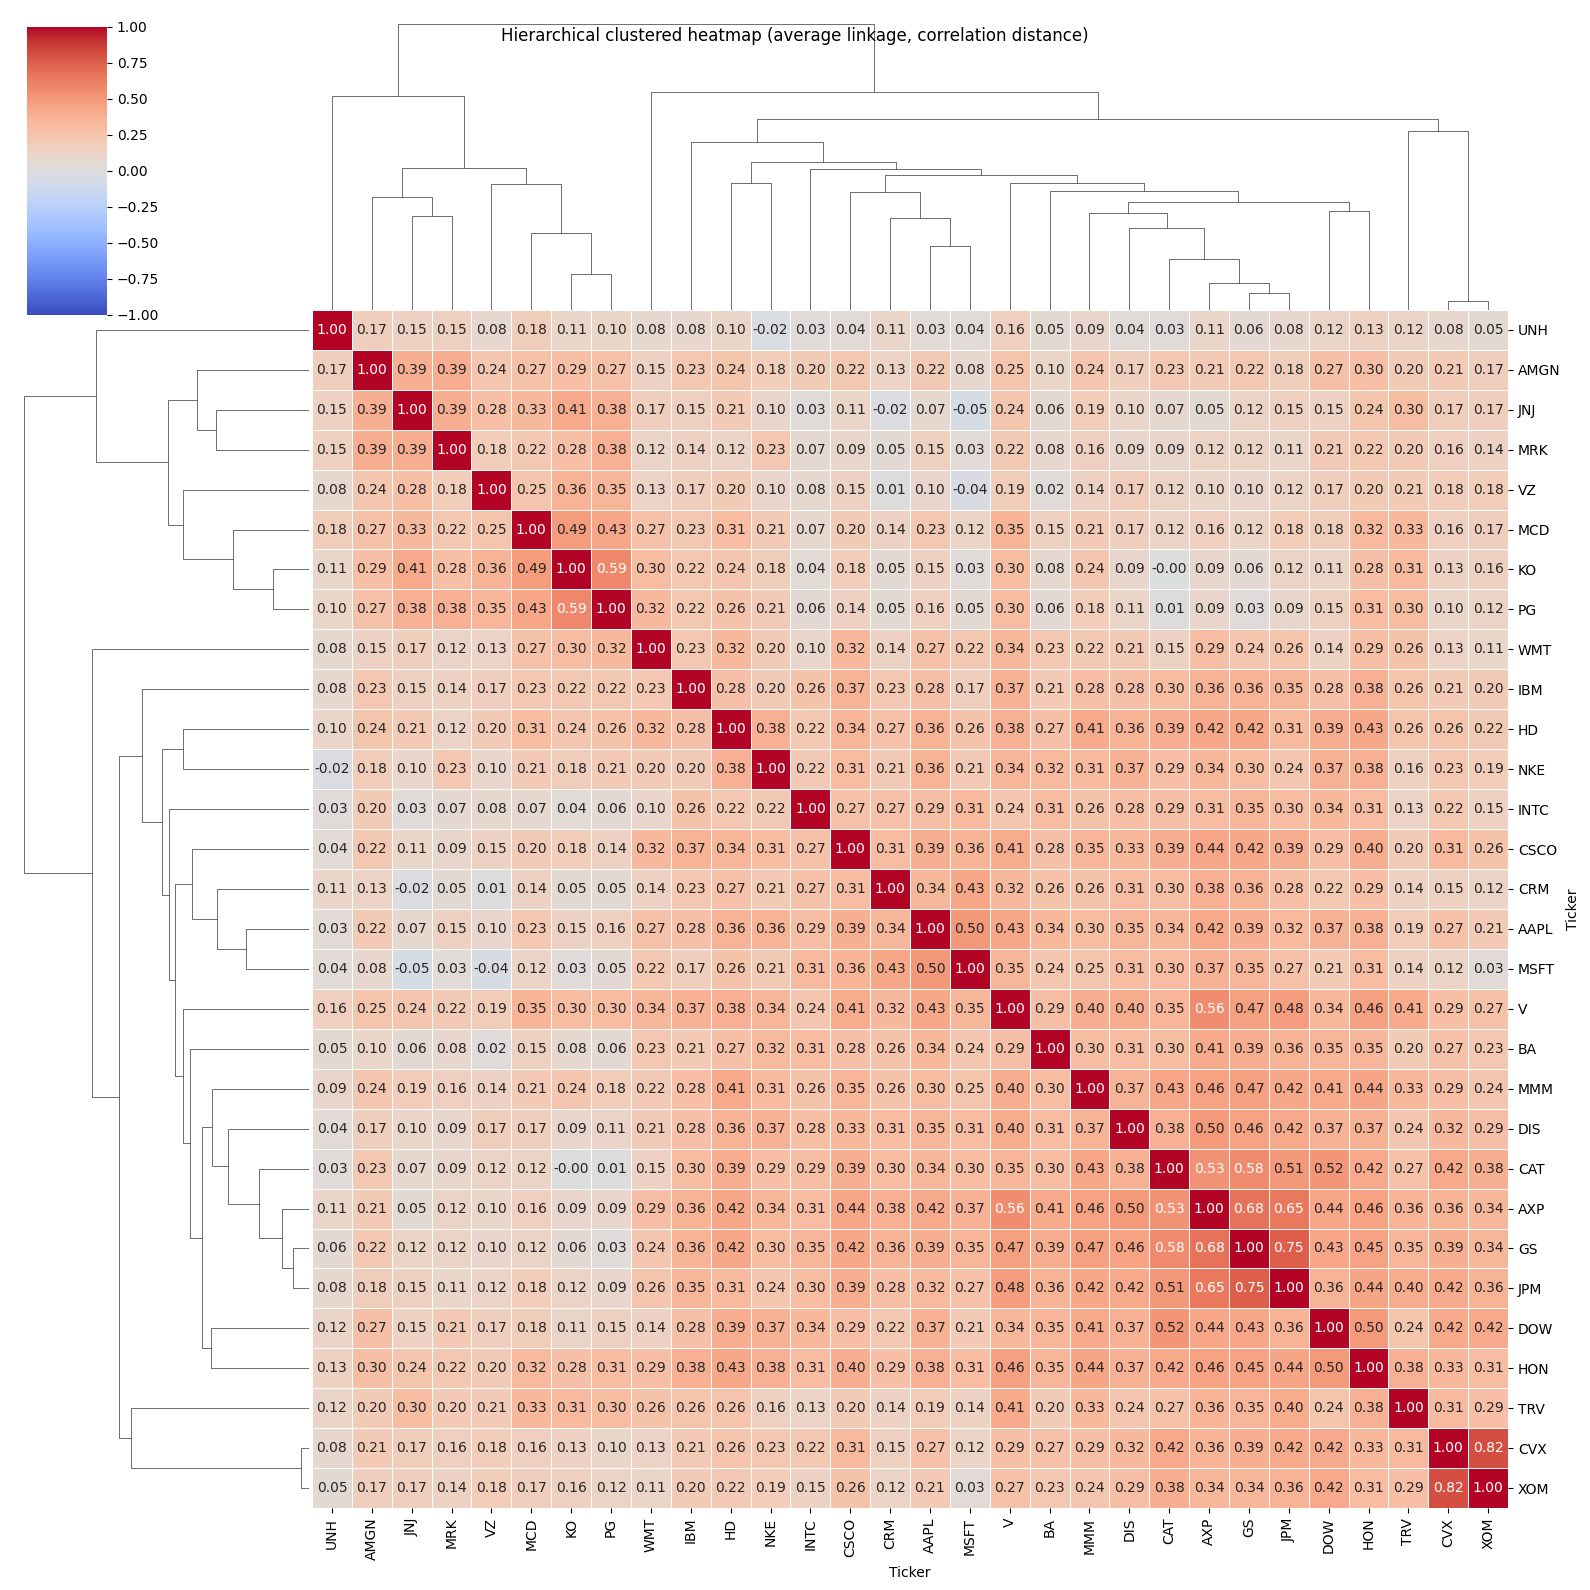

Three clusters (blocks) and their members:
Cluster 1: ['AMGN', 'JNJ', 'KO', 'MCD', 'MRK', 'PG', 'VZ']
Cluster 2: ['AAPL', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JPM', 'MMM', 'MSFT', 'NKE', 'TRV', 'V', 'WMT', 'XOM']
Cluster 3: ['UNH']


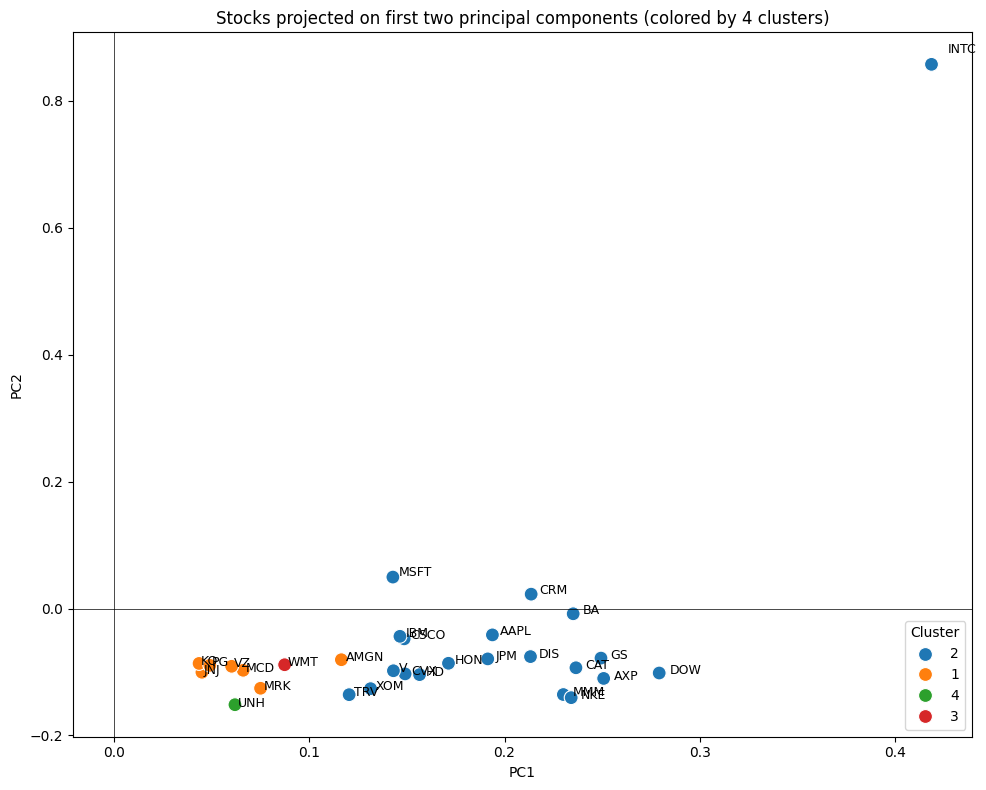

Cluster 1: ['AMGN', 'JNJ', 'KO', 'MCD', 'MRK', 'PG', 'VZ']
Cluster 2: ['AAPL', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JPM', 'MMM', 'MSFT', 'NKE', 'TRV', 'V', 'XOM']
Cluster 3: ['WMT']
Cluster 4: ['UNH']


In [13]:
# Clustered heatmap (clustermap)
sns.clustermap(corr, annot=True, cmap='coolwarm', fmt=".2f", 
            linewidths=0.5, center=0, vmin=-1, vmax=1,
            cbar_kws={"shrink": 0.9}, method='average', metric='correlation',figsize=(16,16))
plt.suptitle('Hierarchical clustered heatmap (average linkage, correlation distance)')
plt.show()

# Identification three most distinct blocks on diagonal

# Convert correlation to distance: distance = 1 - correlation
dist = 1 - corr
# Convert to condensed distance matrix for linkage
condensed = squareform(dist.values, checks=False)
Z = linkage(condensed, method='average')  # hierarchical clustering

# Get cluster labels for 3 clusters
labels_3 = fcluster(Z, 3, criterion='maxclust')
clusters_3 = pd.Series(labels_3, index=corr.index)

# Print blocks
print("Three clusters (blocks) and their members:")
for c in sorted(clusters_3.unique()):
    members = clusters_3[clusters_3 == c].index.tolist()
    print(f"Cluster {c}: {members}")

# Create 4 clusters using the distance matrix and linkage
labels_4 = fcluster(Z, 4, criterion='maxclust')
clusters_4 = pd.Series(labels_4, index=corr.index)

# Projection of stocks onto first two principal components
pca = PCA(n_components=2)
pc_scores = pca.fit_transform(log_returns)
pc_df = pd.DataFrame(pc_scores, index=log_returns.index, columns=['PC1', 'PC2'])

# compute stock loadings on PC1/PC2
stock_coords = pd.DataFrame(pca.components_.T, index=log_returns.columns, columns=['PC1','PC2'])

# Scatter plot PC1 vs PC2 with cluster colors
plt.figure(figsize=(10,8))
sns.scatterplot(data=stock_coords, x='PC1', y='PC2', hue=clusters_4.astype(str), s=100)
for i, txt in enumerate(stock_coords.index):
    plt.text(stock_coords.iloc[i,0]*1.02, stock_coords.iloc[i,1]*1.02, txt, fontsize=9)
plt.title("Stocks projected on first two principal components (colored by 4 clusters)")
plt.axhline(0, color='k', linewidth=0.5)
plt.axvline(0, color='k', linewidth=0.5)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

#Print the four clusters and their member tickers
clusters_dict = {}
for c in sorted(clusters_4.unique()):
    clusters_dict[c] = list(clusters_4[clusters_4==c].index)
    print(f"Cluster {c}: {clusters_dict[c]}")


## Question 3

Oldest ticker: BA starting at 1962-01-02 00:00:00-05:00


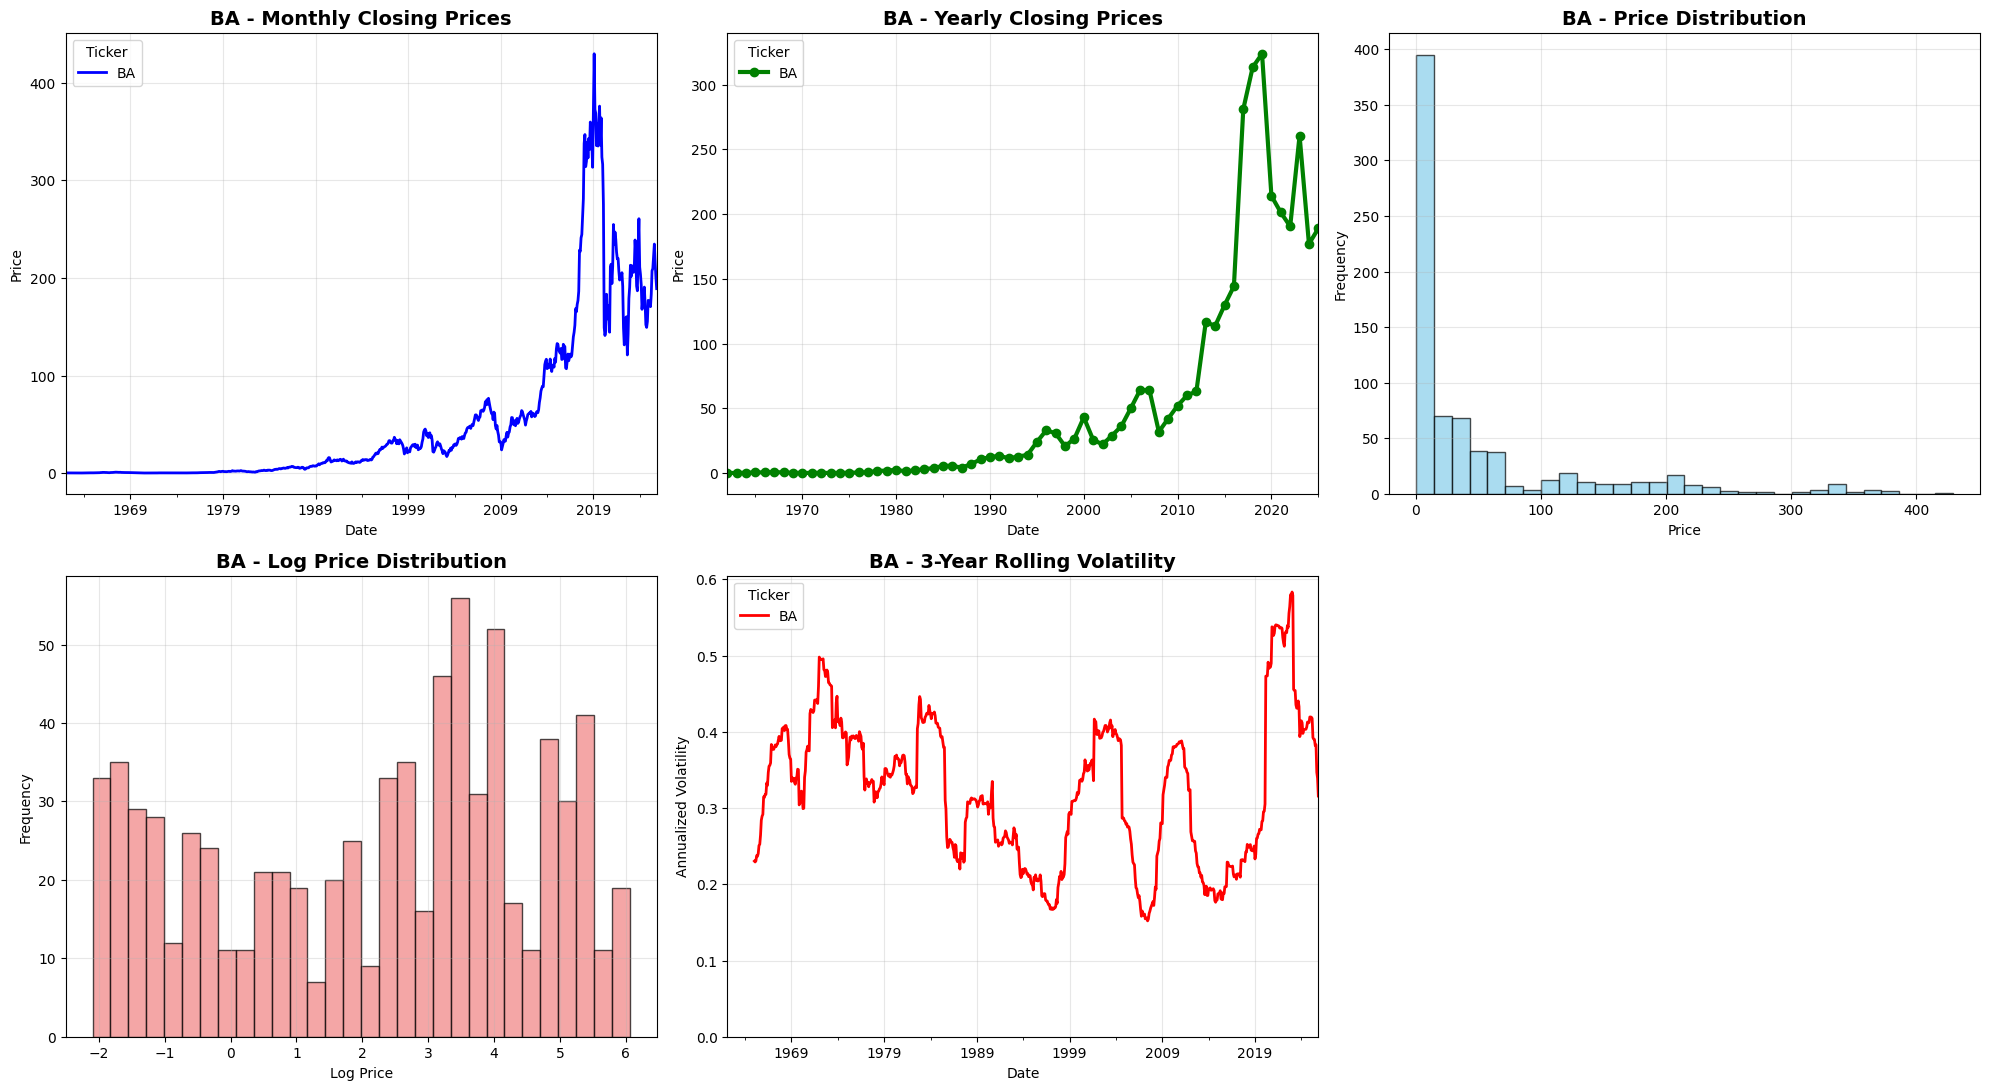

ADF Statistic: -1.042550182457047
p-value: 0.7374306194765821
Critical Value (1%): -3.439
Critical Value (5%): -2.865
Critical Value (10%): -2.569
Series was non-stationary; applied first differencing.
ADF Statistic (diff): -5.650026048171981 p-value: 9.90935681717217e-07


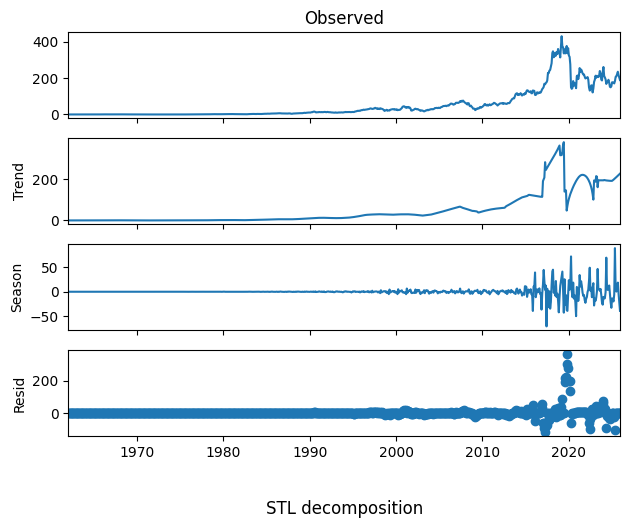

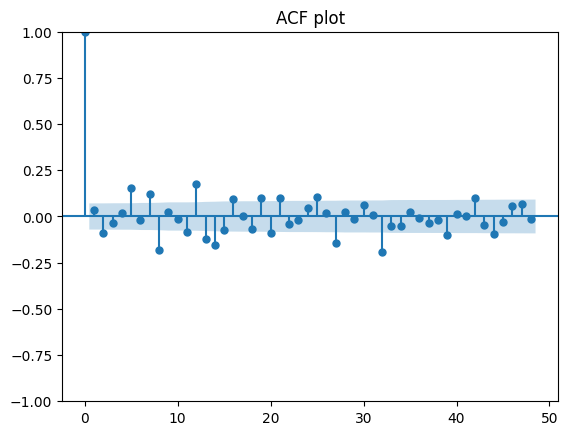

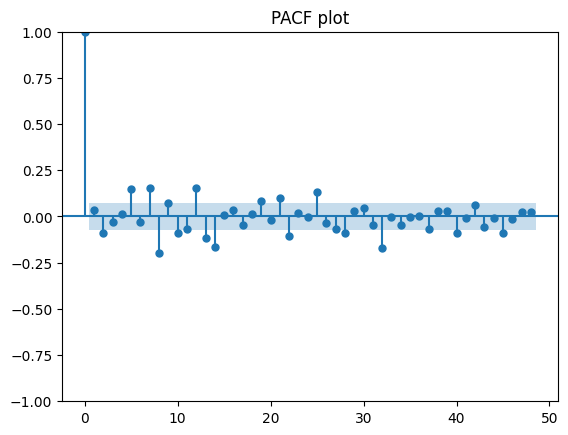

Simple MA (window=12) — MAE: 34.3118, RMSE: 40.6331


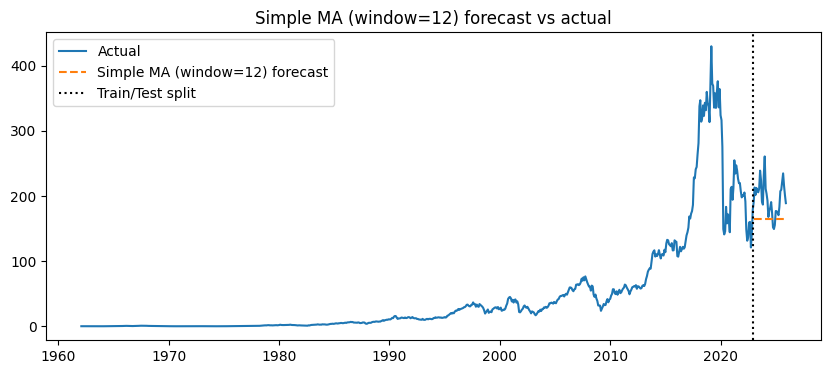

ARIMA(0,1,1) — MAE: 24.2160, RMSE: 30.3476


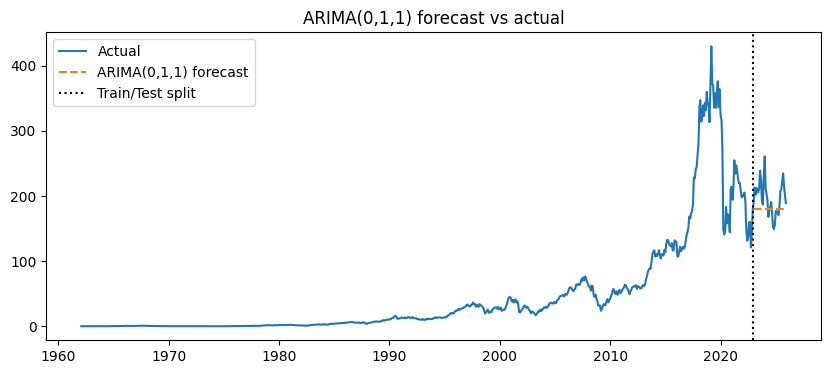

LSTM — MAE: 20.9704, RMSE: 26.0883


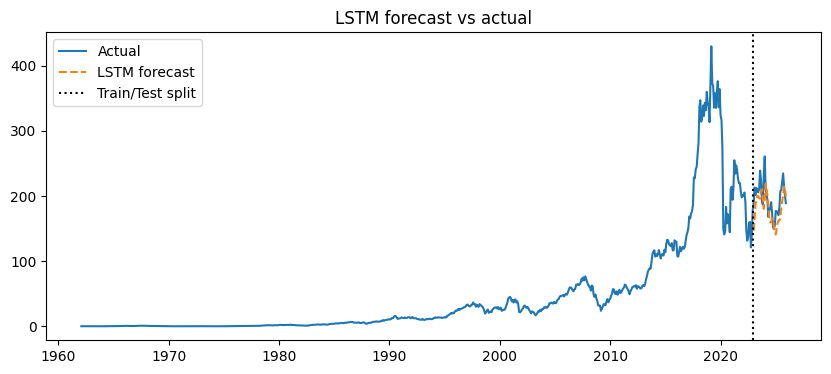

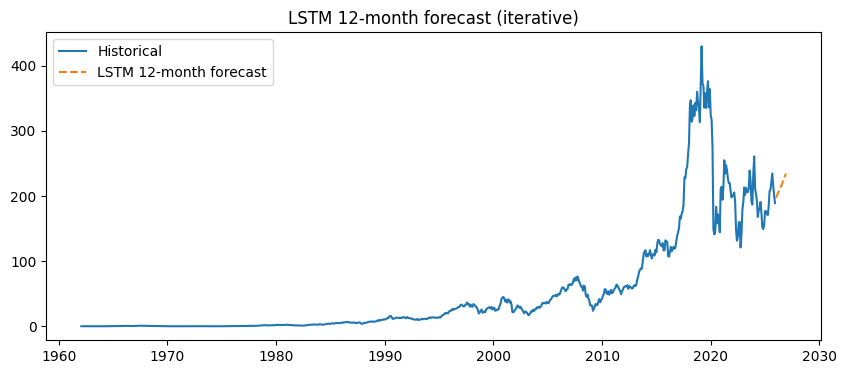

In [21]:
############################# 3.1
# function to choose the oldest ticker (ticker whose historical data starts the earliest)
def get_earliest_history_ticker(tickers):
    earliest = {}
    for t in tickers:
        try:
            meta = yf.Ticker(t).history(period="max")  # fetch history meta
            if not meta.empty:
                earliest_date = meta.index.min()
                earliest[t] = earliest_date
        except Exception as e:
            continue
    if not earliest:
        raise RuntimeError("No historical data found for provided tickers.")
    # return ticker with earliest date
    return min(earliest.items(), key=lambda x: x[1])


oldest_ticker, start_date = get_earliest_history_ticker(djia_tickers)
print("Oldest ticker:", oldest_ticker, "starting at", start_date)

end_date = pd.Timestamp.today().strftime("%Y-%m-%d")

# Fetch monthly closing price series
series = yf.download(oldest_ticker, start=start_date, end=end_date, auto_adjust=True ,progress=False)["Close"]
    

# Plot series
# Create comprehensive visualization grid
fig = plt.figure(figsize=(20, 16))

# 1. Monthly line plot
monthly_data = series.resample('ME').last().dropna()
ax1 = plt.subplot(3, 3, 1)
monthly_data.plot(ax=ax1, color='blue', linewidth=2)
ax1.set_title(f'{oldest_ticker} - Monthly Closing Prices', fontsize=14, fontweight='bold')
ax1.set_ylabel('Price')
ax1.grid(True, alpha=0.3)

# 2. Yearly line plot (resample to yearly)
yearly_data =  series.resample('YE').last().dropna()
ax2 = plt.subplot(3, 3, 2)
yearly_data.plot(ax=ax2, color='green', linewidth=3, marker='o')
ax2.set_title(f'{oldest_ticker} - Yearly Closing Prices', fontsize=14, fontweight='bold')
ax2.set_ylabel('Price')
ax2.grid(True, alpha=0.3)

# 3. Histogram of prices
ax3 = plt.subplot(3, 3, 3)
monthly_data.hist(ax=ax3, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax3.set_title(f'{oldest_ticker} - Price Distribution', fontsize=14, fontweight='bold')
ax3.set_xlabel('Price')
ax3.set_ylabel('Frequency')
ax3.grid(True, alpha=0.3)

# 4. Histogram of log prices
ax4 = plt.subplot(3, 3, 4)
log_prices = np.log(monthly_data)
log_prices.hist(ax=ax4, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
ax4.set_title(f'{oldest_ticker} - Log Price Distribution', fontsize=14, fontweight='bold')
ax4.set_xlabel('Log Price')
ax4.set_ylabel('Frequency')
ax4.grid(True, alpha=0.3)

# 5. Rolling volatility (3-year window = 36 months)
# Calculate monthly log returns first
monthly_returns = np.log(monthly_data / monthly_data.shift(1)).dropna()
rolling_volatility = monthly_returns.rolling(window=36).std() * np.sqrt(12)  # Annualized

ax5 = plt.subplot(3, 3, 5)
rolling_volatility.plot(ax=ax5, color='red', linewidth=2)
ax5.set_title(f'{oldest_ticker} - 3-Year Rolling Volatility', fontsize=14, fontweight='bold')
ax5.set_ylabel('Annualized Volatility')
ax5.set_ylim(bottom=0)
ax5.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#revert series to the monthly data
series = monthly_data;

# ADF test to assess stationarity
adf_result = adfuller(series.dropna())
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for k, v in adf_result[4].items():
    print("Critical Value (%s): %.3f" % (k, v))

stationary_data = False
# If non-stationary (p > 0.05) then difference
if adf_result[1] > 0.05:
    series_diff = series.diff().dropna()
    print("Series was non-stationary; applied first differencing.")
    adf_result2 = adfuller(series_diff)
    print("ADF Statistic (diff):", adf_result2[0], "p-value:", adf_result2[1])
else:
    series_diff = series
    stationary_data = True
    print("Series stationary (no differencing needed).")
    
############################# 3.2
# Seasonality analysis

# STL
stl = STL(series, period=12, robust=True)  # monthly data so period=12
res = stl.fit()
fig = res.plot()
plt.title("STL decomposition",y=-1.0)
plt.show()

# ACF/PACF on differenced series (if differenced), else on series (if stationary)
target = series_diff
plot_acf(target, lags=48)
plt.title("ACF plot")
plt.show()

plot_pacf(target, lags=48)
plt.title("PACF plot")
plt.show()


############################# 3.3
# evaluation window: last 36 months/3 years
eval_months = 36
train_series = series.iloc[:-eval_months]
test_series = series.iloc[-eval_months:]

# Clean NaNs
train_series = train_series.dropna()
test_series = test_series.dropna()

# Force 1D structure
if isinstance(train_series, pd.DataFrame):
    train_series = train_series.iloc[:, 0]
if isinstance(test_series, pd.DataFrame):
    test_series = test_series.iloc[:, 0]


# function to evaluate and plot
def evaluate_and_plot(pred, model_name):
    mae = mean_absolute_error(test_series, pred)
    rmse = math.sqrt(mean_squared_error(test_series, pred))
    print(f"{model_name} — MAE: {mae:.4f}, RMSE: {rmse:.4f}")
    plt.figure(figsize=(10,4))
    plt.plot(series.index, series, label='Actual')
    plt.plot(test_series.index, pred, label=f'{model_name} forecast', linestyle='--')
    plt.axvline(train_series.index[-1], color='k', linestyle=':', label='Train/Test split')
    plt.title(f"{model_name} forecast vs actual")
    plt.legend()
    plt.show()
    return mae, rmse

# Simple Moving Average (MA) forecasting
# We consider the rolling mean of the last N months of training as forecast for each horizon.
window = 12  # simple choice: 12-month moving average
ma_value = train_series.rolling(window=window).mean().iloc[-1]  # last rolling mean
ma_pred = pd.Series(ma_value, index=test_series.index)  # naive persistent forecast
ma_metrics = evaluate_and_plot(ma_pred, "Simple MA (window=12)")


# ARIMA / SARIMA forecasting
# No seasonality pattern observed so we use ARIMA
# From ACF/PACF 
# No strong AR terms so we can take p = 0 or 1
# No strong MA terms so we can take q = 0 or 1
# From ADF, the first differencing gives stationarity so d = 1
p, d, q = 0, 1, 1

arima_model = ARIMA(train_series, order=(p, d, q))
arima_fit = arima_model.fit()
# Forecast
forecast_steps = len(test_series)
arima_pred = arima_fit.forecast(steps=forecast_steps)
arima_metrics = evaluate_and_plot(arima_pred, f"ARIMA({p},{d},{q})")


# LSTM forecasting
# Preprocessing: scale series to (0,1)
scaler = MinMaxScaler()
train_vals = train_series.values.reshape(-1,1)
test_vals = test_series.values.reshape(-1,1)
scaler.fit(train_vals)
train_scaled = scaler.transform(train_vals)
test_scaled = scaler.transform(test_vals)

# Function to create sequences for supervised learning
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        xs.append(data[i:i+seq_length])
        ys.append(data[i+seq_length])
    return np.array(xs), np.array(ys)

seq_length = 12  # past 12 months to predict next
X_train, y_train = create_sequences(train_scaled, seq_length)

# Build small LSTM
tf.keras.backend.clear_session()
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Reshape X
if X_train.ndim == 2:
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

history = model.fit(X_train, y_train, epochs=200, batch_size=16, verbose=0, callbacks=[early_stop])

# Walk-forward forecasting over test period
def lstm_forecast_walkforward(model, train_scaled, test_scaled, seq_length, scaler):
    history = train_scaled.copy()
    preds = []
    for i in range(len(test_scaled)):
        # create input sequence from last seq_length points of history
        x_input = history[-seq_length:].reshape(1, seq_length, 1)
        yhat = model.predict(x_input, verbose=0)
        preds.append(yhat.ravel()[0])
        # append actual test value to history for next step (teacher forcing)
        history = np.vstack([history, test_scaled[i].reshape(1,1)])
    preds = np.array(preds).reshape(-1,1)
    preds_rescaled = scaler.inverse_transform(preds)
    return preds_rescaled.flatten()

lstm_pred = lstm_forecast_walkforward(model, train_scaled, test_scaled, seq_length, scaler)
lstm_pred_series = pd.Series(lstm_pred, index=test_series.index)

lstm_metrics = evaluate_and_plot(lstm_pred_series, "LSTM")



# Refit LSTM on full series
full_vals = series.values.reshape(-1,1)
scaler = MinMaxScaler(); scaler.fit(full_vals)
full_scaled = scaler.transform(full_vals)

# create X,Y for training full
seq_length = 12
X_full, y_full = create_sequences(full_scaled, seq_length)
if X_full.ndim == 2:
    X_full = X_full.reshape((X_full.shape[0], X_full.shape[1], 1))

tf.keras.backend.clear_session()
model_full = Sequential([
    Input(shape=(X_full.shape[1], X_full.shape[2])),
    LSTM(50),
    Dense(1)
])
model_full.compile(optimizer='adam', loss='mse')
model_full.fit(X_full, y_full, epochs=100, batch_size=16, verbose=0, callbacks=[EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)])

# Iterative forecast 12 steps ahead (use predictions as input for next step)
history = full_scaled.copy()
preds = []
for i in range(12):
    x_input = history[-seq_length:].reshape(1, seq_length, 1)
    yhat = model_full.predict(x_input, verbose=0)
    preds.append(yhat.ravel()[0])
    history = np.vstack([history, yhat])  # append predicted (not actual)

preds = np.array(preds).reshape(-1,1)
preds_rescaled = scaler.inverse_transform(preds).flatten()
pred_index = pd.date_range(start=series.index[-1] + pd.offsets.MonthEnd(1), periods=12, freq='ME')
lstm_future = pd.Series(preds_rescaled, index=pred_index)

# Plot
plt.figure(figsize=(10,4))
plt.plot(series.index, series, label="Historical")
plt.plot(lstm_future.index, lstm_future, label="LSTM 12-month forecast", linestyle='--')
plt.legend()
plt.title("LSTM 12-month forecast (iterative)")
plt.show()

